In [1]:
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from scipy.interpolate import CubicSpline

## Option B declustering and Simple Kriging Estimate

In [2]:
ALL_SPT = pd.read_excel('ALL_SPT.xlsx')
DEM = pd.read_excel('SAMPLE_DEM.xlsx')

### In Option B declustering

##### iminmax = 0 is used when your data is clustered at the minimum values, 1 is used for high clustered values 
##### See Github account for geostatspy for use. When using geostatspy see related dependancies.

In [3]:
wts, cell_sizes, dmeans = geostats.declus(ALL_SPT,'X','Y','ISPT_NVAL',iminmax = 0, noff= 10, ncell=500,cmin=250,cmax=20000)
ALL_SPT['Wts'] = wts

There are 291 data with:
   mean of      13.653152400020858 
   min and max  1.0 and 45.9
   standard dev 9.041329411653416 


100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:01<00:00, 258.45it/s]


In [4]:
ALL_SPT

,X,Y,LOCA_GL,ISPT_NVAL,Wts
0,334684.5631,3.064437e+06,1287.854004,8.454545,0.294822
1,334684.7631,3.064437e+06,1287.854004,8.478261,0.294822
2,334684.9631,3.064437e+06,1287.854004,8.913043,0.294822
3,334685.1631,3.064437e+06,1287.854004,8.565217,0.294822
4,334685.3631,3.064437e+06,1287.854004,9.916667,0.294822
...,...,...,...,...,...
286,345323.9366,3.060381e+06,1356.000000,7.400000,3.957155
287,335092.4152,3.051061e+06,1506.800000,11.200000,6.797990
288,342493.9384,3.062140e+06,1299.010000,5.833333,2.077381
289,326404.7350,3.064645e+06,1353.240000,2.600000,3.110885


13.65 15.28


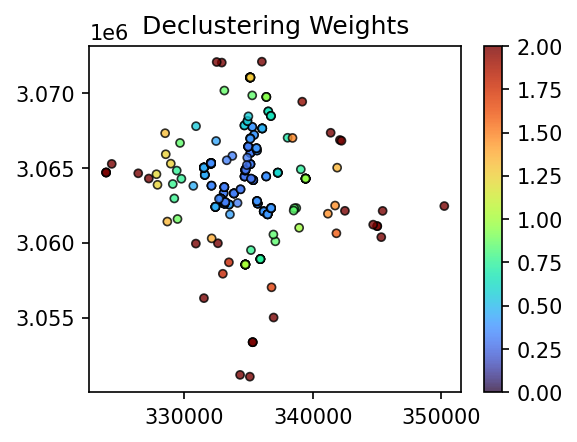

In [5]:
fig, ax = plt.subplots(figsize=(4,3),dpi=150)

im = ax.scatter(ALL_SPT['X'],ALL_SPT['Y'],s=15,c=ALL_SPT['Wts'],marker='o',cmap=plt.cm.turbo,alpha=0.8, lw=0.8, ec='k',vmin=0, vmax=2)
cbar = plt.colorbar(im,ax=ax)
ax.set_title('Declustering Weights'); ax.set_xlabel('')

mean = round(np.average(ALL_SPT['ISPT_NVAL'].values),2)
declust_mean = round(np.average(ALL_SPT['ISPT_NVAL'].values,weights=ALL_SPT['Wts'].values),2)
print(mean,declust_mean)

#### Distribution before declustering

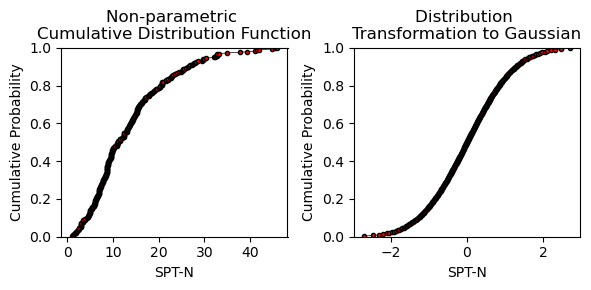

In [6]:
data_sort = np.sort(ALL_SPT['ISPT_NVAL'])
cprob = []
n = len(data_sort)
for i in range(n):
    cprob.append((i+1)/n)

y = []
for i in range(n):
    y.append(norm.ppf(cprob[i],loc=0,scale=1))
    
fig, axs = plt.subplots(1,2,figsize=(6,3))
axs = axs.flatten(); 
ax = axs[0]; plt.sca(ax)
ax.plot(data_sort,cprob,c='k',marker='o',ms=3,lw=0.5,mfc='r')
ax.set_xlabel('SPT-N'); ax.set_ylabel('Cumulative Probability'); ax.set_title('Non-parametric \nCumulative Distribution Function')
ax.set_ylim(0,1)

ax = axs[1]; plt.sca(ax)
ax.set_xlabel('SPT-N'); ax.set_ylabel('Cumulative Probability'); ax.set_title('Distribution \nTransformation to Gaussian')
ax.plot(y,cprob,c='k',marker='o',ms=3,lw=0.5,mfc='r')
ax.set_ylim(0,1)

plt.tight_layout()

#### Distribution after declustering

In [7]:
#sort df for SPT values
calc = ALL_SPT.sort_values('ISPT_NVAL').reset_index(drop=False)

#find declustered CDF
CDF_declusterd = {}

for i in range(len(calc['Wts'])):
    if i == 0:
        CDF_declusterd[i] = calc.loc[i]['Wts']/(np.sum(calc['Wts'])+1)
    else:
        CDF_declusterd[i] = calc.loc[i]['Wts']/(np.sum(calc['Wts'])+1)+CDF_declusterd[i-1]

calc['cdf_w'] = pd.Series(CDF_declusterd)

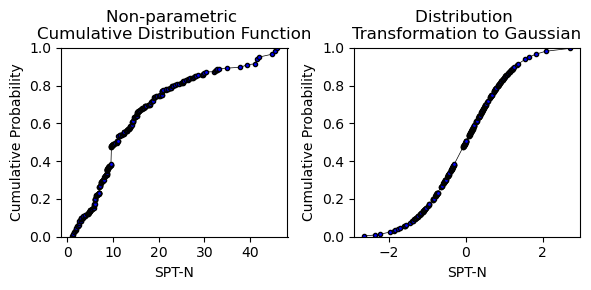

In [8]:
calc['NVS'] = norm.ppf(calc['cdf_w'],loc=0,scale=1)

fig, axs = plt.subplots(1,2,figsize=(6,3))
axs = axs.flatten(); 
ax = axs[0]; plt.sca(ax)
ax.plot(calc['ISPT_NVAL'],calc['cdf_w'],c='k',marker='o',ms=3,lw=0.5,mfc='b')
ax.set_xlabel('SPT-N'); ax.set_ylabel('Cumulative Probability'); ax.set_title('Non-parametric \nCumulative Distribution Function')
ax.set_ylim(0,1)

ax = axs[1]; plt.sca(ax)
ax.set_xlabel('SPT-N'); ax.set_ylabel('Cumulative Probability'); ax.set_title('Distribution \nTransformation to Gaussian')
ax.plot(calc['NVS'],calc['cdf_w'],c='k',marker='o',ms=3,lw=0.5,mfc='b')
ax.set_ylim(0,1)

plt.tight_layout()

### Compare

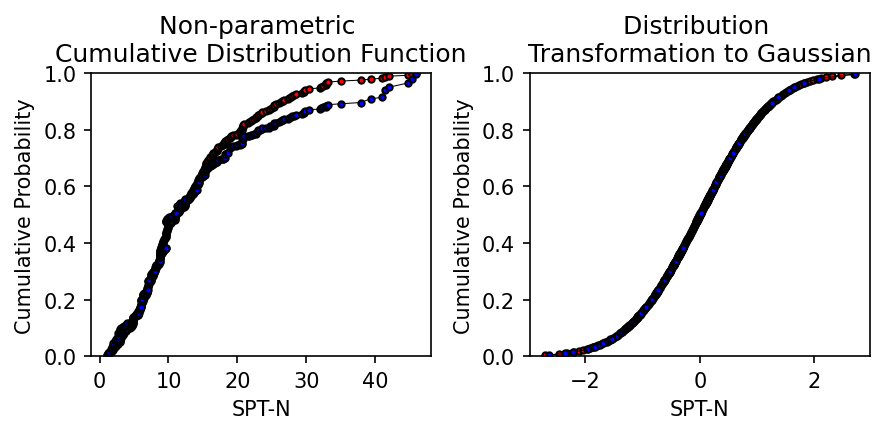

In [9]:
fig, axs = plt.subplots(1,2,figsize=(6,3),dpi=150)
axs = axs.flatten(); 
ax = axs[0]; plt.sca(ax)
ax.plot(data_sort,cprob,c='k',marker='o',ms=3,lw=0.5,mfc='r')
ax.plot(calc['ISPT_NVAL'],calc['cdf_w'],c='k',marker='o',ms=3,lw=0.5,mfc='b')

ax.set_xlabel('SPT-N'); ax.set_ylabel('Cumulative Probability'); ax.set_title('Non-parametric \nCumulative Distribution Function')
ax.set_ylim(0,1)

ax = axs[1]; plt.sca(ax)
ax.set_xlabel('SPT-N'); ax.set_ylabel('Cumulative Probability'); ax.set_title('Distribution \nTransformation to Gaussian')
ax.plot(y,cprob,c='k',marker='o',ms=3,lw=0.5,mfc='r')
ax.plot(calc['NVS'],calc['cdf_w'],c='k',marker='o',ms=3,lw=0.5,mfc='b')
ax.set_ylim(0,1)

plt.tight_layout()

In [10]:
f_bins = [0,5,10,15,20,25,30,35,40,45,50]
def p_norm_fit(df, values, bins): # fit MLE of the distribution
    extents = np.linspace(np.min(bins),np.max(bins),1000)
    fit_mean, fit_stdev = norm.fit(df[values],loc=df[values].mean(), scale=df[values].std())  
    prob = norm.pdf(extents, loc=fit_mean, scale=fit_stdev)
    cumul = norm.cdf(extents, loc=fit_mean, scale=fit_stdev)
    return (extents,cumul,prob)

In [11]:
extents_K_SPT, norm_K_SPT, pnorm_K_SPT = p_norm_fit(calc, 'ISPT_NVAL', f_bins)

In [12]:
def simple_kriging(data_df,param): # debias df - return krig results and map elements
    #make grid for unknowns (same as in Step 1)
    xmin = 320000; xmax = 356000; ymin = 3050000; ymax = 3077500               
    xran = xmax-xmin; yran = ymax-ymin; xsiz = 1000; ysiz = 1000                   
    x_side = np.linspace(xmin+(0.5*xsiz),xmax-(0.5*xsiz),xran//xsiz)
    y_side = np.linspace(ymin+(0.5*xsiz),ymax-(0.5*ysiz),yran//ysiz)
    X_CELL, Y_CELL = np.meshgrid(x_side,y_side)
    CELL = np.array([np.hstack(X_CELL),np.hstack(Y_CELL)])
    
    
    #in vario insert results of using geostatspy variogram creation
    vario = {'nug': 0.0,'nst': 2,'it1': 1,'cc1': 0.9,'azi1': 90,'hmaj1': 4000,'hmin1': 4000,'it2': 1,'cc2': 0.1,'azi2': 90,'hmaj2': 7000,'hmin2': 7000}
    SEP_D = {}; V_M = {}; C_M = {}
    
    #simple kriging
    for i,j in zip(range(len(data_df['X'])),range(len(data_df['Y']))):
        SEP_D[i,j] = (np.sqrt((data_df.loc[i]['X']-data_df['X'])**2+(data_df.loc[i]['Y']-data_df['Y'])**2))
        V_M[i,j] = 1.5*SEP_D[i,j]/vario['hmaj1']-(0.5*(SEP_D[i,j]/vario['hmaj1'])**3)
        C_M[i,j] = np.sum(vario['nug']+vario['it1'])-V_M[i,j]

    S = pd.DataFrame(SEP_D.values()); VAR_M = pd.DataFrame(V_M.values()); COV_M = pd.DataFrame(C_M.values())
    I = np.linalg.inv(COV_M.to_numpy())

    DIST = {}; V = {}; C_x = {}
    for unkx,unky in zip(CELL[0],CELL[1]):
        DIST[unkx,unky] = {}; V[unkx,unky] = {}; C_x[unkx,unky] = {}
        for x,y in zip(data_df['X'],data_df['Y']):
            DIST[unkx,unky][x,y] = np.sqrt((x-unkx)**2+(y-unky)**2)
            V[unkx,unky][x,y] =  1.5*DIST[unkx,unky][x,y]/vario['hmaj1']-(0.5*(DIST[unkx,unky][x,y]/vario['hmaj1'])**3)
            C_x[unkx,unky][x,y] = np.sum(vario['nug']+vario['it1'])-V[unkx,unky][x,y]
    
    WEIGHT_DF = {}; Simp_krig = {}; Krig_var = {}
    for c in C_x.keys():
        WEIGHT_DF[c] = pd.DataFrame(data_df)
        WEIGHT_DF[c]['Weights'] = I@np.array(list(C_x[c].values()))
        WEIGHT_DF[c]['residual'] = WEIGHT_DF[c]['NVS']
        WEIGHT_DF[c]['R+W'] = WEIGHT_DF[c]['residual'] * WEIGHT_DF[c]['Weights']
        Simp_krig[c] = np.sum(WEIGHT_DF[c]['R+W'])
        Krig_var[c] = np.sum(vario['nug']+vario['it1']) - np.sum((WEIGHT_DF[c]['Weights']*list(C_x[c].values()))) 
    
    #backtransform      
    KRIG = pd.DataFrame(data=Simp_krig.values(),index=Simp_krig.keys()).reset_index().rename(columns={'level_0':'X_UNK','level_1':'Y_UNK',0:'gaus'}).set_index(['X_UNK','Y_UNK'])
    postmean = pd.DataFrame({'PMean':KRIG['gaus']})
    x, i = np.unique(data_df['cdf_w'],return_index=True)
    cs = CubicSpline(data_df['cdf_w'].iloc[i],data_df['ISPT_NVAL'].iloc[i])
    bkpost = np.reshape(cs(norm.cdf(postmean['PMean'])),(27,36))
    
    KRIG['param'] = bkpost.flatten()
    VAR = pd.DataFrame(data=Krig_var.values(),index=Krig_var.keys()).reset_index().rename(columns={'level_0':'X_UNK','level_1':'Y_UNK',0:'Var'}).set_index(['X_UNK','Y_UNK'])
    SIMPLE_KRIG = KRIG.join(VAR).reset_index()
    KRIG = KRIG.reset_index()
    X = KRIG['X_UNK'].to_numpy().reshape(X_CELL.shape[0],X_CELL.shape[1])
    Y = KRIG['Y_UNK'].to_numpy().reshape(X_CELL.shape[0],X_CELL.shape[1])
    param = KRIG['param'].to_numpy().reshape(X_CELL.shape[0],X_CELL.shape[1])
    return (SIMPLE_KRIG,X,Y,param)

In [13]:
KRIG,X,Y,param = simple_kriging(calc,'NVS')

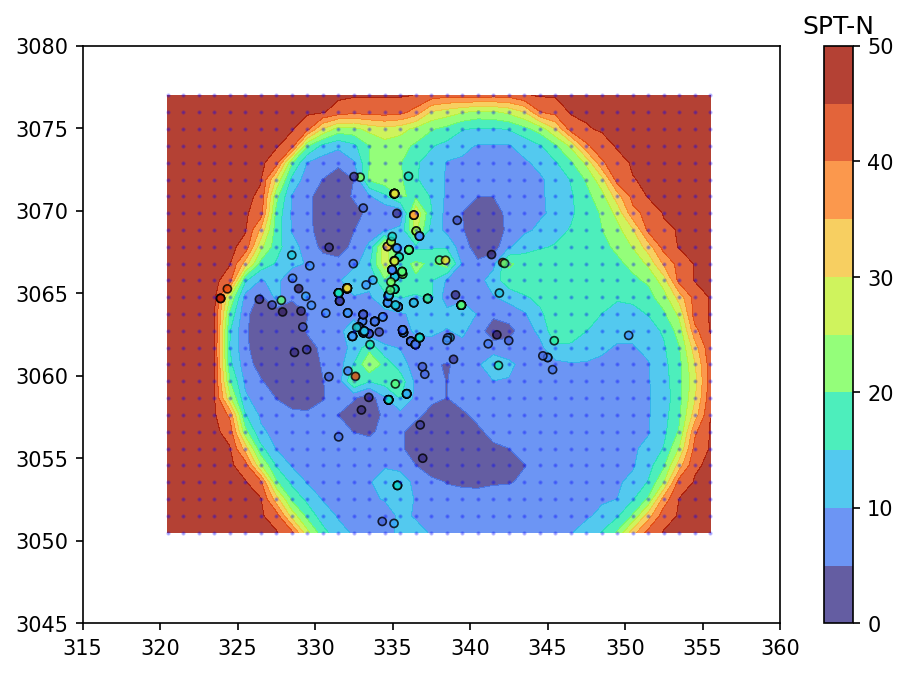

In [14]:
fig, ax = plt.subplots(figsize=(7.5,5),dpi=150)
plt.sca(ax); ax.set_xlim(315*10**3,360*10**3);ax.set_ylim(3045*10**3,3080*10**3)
ax.ticklabel_format(useOffset=False, style='scientific',axis='both',scilimits=(3,3))
ax.xaxis.offsetText.set_visible(False); ax.yaxis.offsetText.set_visible(False)

norm1 = mpl.colors.Normalize(vmin=0,vmax=50); levels = [0,5,10,15,20,25,30,35,40,45,50]
ax.plot(X,Y,marker='o',color='b',lw=0,ms=1,alpha=0.25)
cp = plt.contourf(X,Y,param,levels=[0,5,10,15,20,25,30,35,40,45,50],cmap=plt.cm.turbo, norm=norm1, vmin=0, vmax=50,alpha=0.8)
cbar = plt.colorbar(cp,ax=ax)
cbar.ax.set_title('SPT-N')
im = ax.scatter(ALL_SPT['X'],ALL_SPT['Y'],s=15, c=ALL_SPT['ISPT_NVAL'], marker='o', cmap=plt.cm.turbo, norm=norm1, alpha=0.8, linewidths=0.8, edgecolors="black")

In [15]:
KRIG.to_excel('2.1_Primary_SPT.xlsx')

### Multi-krig

In [16]:
calc['N_DEM'] = (calc['LOCA_GL'] - np.mean(calc['LOCA_GL']))/np.std(calc['LOCA_GL'],ddof=1)
DEM['NDEM'], tvus, tnsus = geostats.nscore(DEM, 'DEM')
DEM_raster = DEM['NDEM'].to_numpy().reshape(27,36) #  equal to X_CELL.shape[0],X_CELL.shape[1]

In [17]:
left = calc.loc[:,['N_DEM']].corr().values
right = np.asarray([calc.loc[:,'NVS'].corr(calc.loc[:,'N_DEM'])])

left_inv = np.linalg.inv(left)
wts = left_inv @ right
smean = DEM_raster * wts[0]
svar = np.full(shape=(27,36),fill_value=(1-wts[0]*right[0]))

Prim_mean = KRIG['gaus'].to_numpy().reshape(27,36)
Prim_var = KRIG['Var'].to_numpy().reshape(27,36)
postmean = (smean * Prim_var + Prim_mean * svar) / (Prim_var-Prim_var*svar + svar)
postvar = (Prim_var*svar) / (Prim_var-Prim_var*svar + svar)

x, i = np.unique(calc['cdf_w'],return_index=True)
cs = CubicSpline(calc['cdf_w'].iloc[i],calc['ISPT_NVAL'].iloc[i])
bkpost = np.reshape(cs(norm.cdf(postmean.flatten())),(27,36))
KRIG['Secondarymean'] = smean.flatten(); KRIG['svar'] = svar.flatten(); KRIG['Postmean'] = bkpost.flatten(); KRIG['Postvar'] = postvar.flatten()
X = KRIG['X_UNK'].to_numpy().reshape(27,36)
Y = KRIG['Y_UNK'].to_numpy().reshape(27,36)

Text(0.5, 1.0, 'Av.SPT')

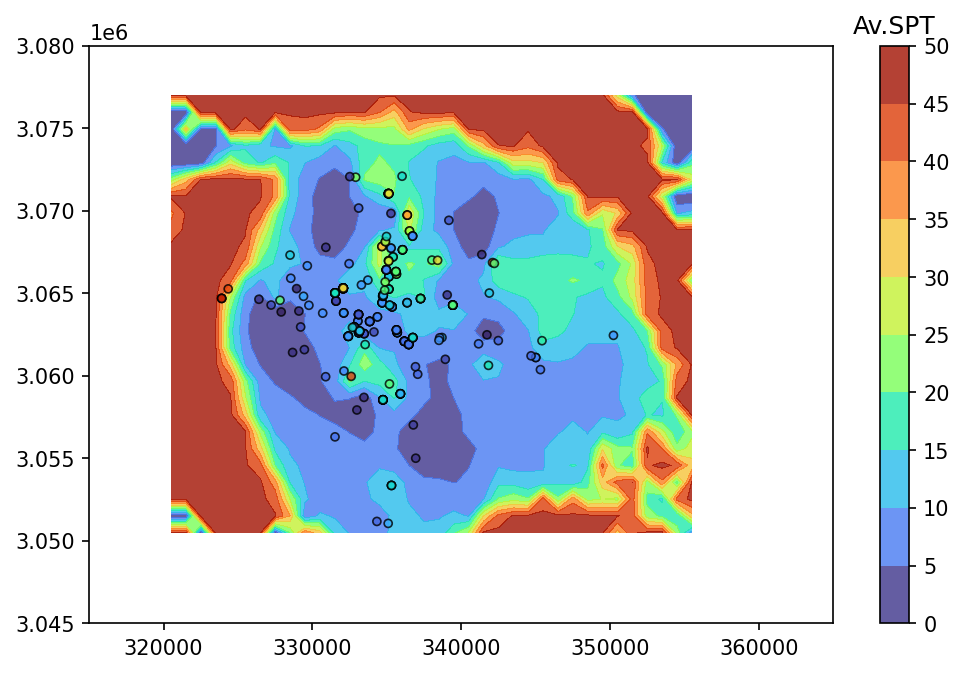

In [18]:
fig, ax = plt.subplots(figsize=(8,5),dpi=150)
plt.sca(ax); ax.set_xlim(315*10**3,365*10**3);ax.set_ylim(3045*10**3,3080*10**3)
norm1 = mpl.colors.Normalize(vmin=0,vmax=50); levels = [0,5,10,15,20,25,30,35,40,45,50]

cp = plt.contourf(X,Y,bkpost,levels=levels,cmap=plt.cm.turbo, norm=norm1,alpha=0.8)
im = ax.scatter(ALL_SPT['X'],ALL_SPT['Y'],s=15, c=ALL_SPT['ISPT_NVAL'], marker='o', cmap=plt.cm.turbo, norm=norm1, alpha=0.8, linewidths=0.8, edgecolors="black")
cbar = plt.colorbar(cp,ax=ax,ticks=levels)
cbar.ax.set_title('Av.SPT')

In [19]:
KRIG.to_excel('2.1_Multi_Krig.xlsx')